In [1]:
import numpy as np
import xarray as xr
from ctsm_py import utils
import matplotlib.pyplot as plt
import warnings
import glob

In [2]:
pftname =   ["needleleaf_evergreen_temperate_tree",
             "needleleaf_evergreen_boreal_tree",
             "needleleaf_deciduous_boreal_tree",
             "broadleaf_evergreen_tropical_tree",
             "broadleaf_evergreen_temperate_tree",
             "broadleaf_deciduous_tropical_tree",
             "broadleaf_deciduous_temperate_tree",
             "broadleaf_deciduous_boreal_tree",
             "broadleaf_evergreen_shrub",
             "broadleaf_deciduous_temperate_shrub",
             "broadleaf_deciduous_boreal_shrub",
             "c3_arctic_grass",
             "c3_non-arctic_grass",
             "c4_grass",
             "unmanaged_c3_crop",
             "unmanaged_c3_irrigated",
             "temperate_corn",
             "irrigated_temperate_corn",
             "spring_wheat",
             "irrigated_spring_wheat",
             "winter_wheat",
             "irrigated_winter_wheat",
             "soybean",
             "irrigated_soybean",
             "barley",
             "irrigated_barley",
             "winter_barley",
             "irrigated_winter_barley",
             "rye",
             "irrigated_rye",
             "winter_rye",
             "irrigated_winter_rye",
             "cassava",
             "irrigated_cassava",
             "citrus",
             "irrigated_citrus",
             "cocoa",
             "irrigated_cocoa",
             "coffee",
             "irrigated_coffee",
             "cotton",
             "irrigated_cotton",
             "datepalm",
             "irrigated_datepalm",
             "foddergrass",
             "irrigated_foddergrass",
             "grapes",
             "irrigated_grapes",
             "groundnuts",
             "irrigated_groundnuts",
             "millet",
             "irrigated_millet",
             "oilpalm",
             "irrigated_oilpalm",
             "potatoes",
             "irrigated_potatoes",
             "pulses",
             "irrigated_pulses",
             "rapeseed",
             "irrigated_rapeseed",
             "rice",
             "irrigated_rice",
             "sorghum",
             "irrigated_sorghum",
             "sugarbeet",
             "irrigated_sugarbeet",
             "sugarcane",
             "irrigated_sugarcane",
             "sunflower",
             "irrigated_sunflower",
             "miscanthus",
             "irrigated_miscanthus",
             "switchgrass",
             "irrigated_switchgrass",
             "tropical_corn",
             "irrigated_tropical_corn",
             "tropical_soybean",
             "irrigated_tropical_soybean"]

In [3]:
# Get list of all files in $indir matching $pattern
indir = "/Volumes/Reacher/CESM_runs/numa_20211014/"
pattern = "*h1.*-01-01-00000.nc"
filelist = glob.glob(indir + pattern)

# Set up function to drop unwanted vars in preprocessing of open_mfdataset()
def mfdataset_preproc(ds):
    vars_to_import = list(ds.dims) + \
        ["CPHASE", 
        "GDDHARV", 
        "GDDPLANT", 
        "GPP", 
        "GRAINC_TO_FOOD", 
        "NPP", 
        "TLAI", 
        "TOTVEGC", 
        "pfts1d_itype_veg"]
    varlist = list(ds.variables)
    vars_to_drop = list(np.setdiff1d(varlist, vars_to_import))
    ds = ds.drop_vars(vars_to_drop)
    ds = xr.decode_cf(ds, decode_times = True)
    return ds

# Import
this_ds = xr.open_mfdataset(filelist, \
    concat_dim="time", 
    preprocess=mfdataset_preproc)
# this_ds = utils.time_set_mid(this_ds, 'time')

# Get dates in a format that matplotlib can use
with warnings.catch_warnings():
    # Ignore this warning in this with-block
    warnings.filterwarnings("ignore", message="Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.")
    datetime_vals = this_ds.indexes["time"].to_datetimeindex()

# Get PFT list, integers (use only first timestep)
vegtype_int = this_ds.pfts1d_itype_veg
vegtype_int.values = vegtype_int.values.astype(int)
if not all((vegtype_int.values == vegtype_int.values[0,:]).all(axis=1)):
    raise ValueError("Some veg type changes over time")
vegtype_int = vegtype_int[0,:]

# Get PFT list, strings
vegtype_str = list(np.array(pftname)[vegtype_int.values])

## Read variable and trim to crops

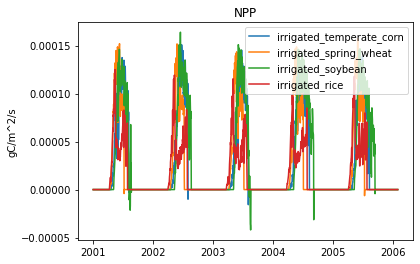

In [16]:
# Which variable?
thisVar = "NPP"

# Make DataArray for this variable
thisvar_da = np.array(this_ds.variables[thisVar])
theseDims = this_ds.variables[thisVar].dims
thisvar_da = xr.DataArray(thisvar_da, 
    dims = theseDims)

# Define coordinates of this variable's DataArray
dimsDict = dict()
for thisDim in theseDims:
    if thisDim == "time":
        dimsDict[thisDim] = this_ds.time
    elif thisDim == "pft":
        dimsDict[thisDim] = vegtype_str
    else:
        raise ValueError("Unknown dimension for coordinate assignment: " + thisDim)
thisvar_da = thisvar_da.assign_coords(dimsDict)

# Trim to managed crops
def is_this_mgd_crop(x):
    notcrop_list = ["tree", "grass", "shrub", "unmanaged"]
    return not any(n in x for n in notcrop_list)
is_crop = [ is_this_mgd_crop(x) for x in thisvar_da.pft.values ]
thisvar_da = thisvar_da[:, is_crop]

# Plot
for p in np.arange(0,np.size(thisvar_da.pft.values)):
    this_pft_char = thisvar_da.pft.values[p]
    plt.plot(datetime_vals, thisvar_da.values[:,p], label = this_pft_char)
plt.title(thisVar)
plt.ylabel(this_ds.variables[thisVar].attrs['units'])
plt.legend()
plt.show()

## Get sowing and harvest date for each crop